In [1]:
import os
import scipy
import time
import pandas
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import BatchNormalization, Conv1D
from keras.utils import np_utils
from keras.layers import Conv1D
from sklearn.model_selection import train_test_split


Using TensorFlow backend.


In [2]:
#Equations

def SHO_fit_func(wvec, *parms):
        #SHO Fit function
        
        Amp, w_0, Q, phi = parms
        w0 = 340E5
        wmax = 360E5
        Amp = 1E-3 * Amp
        w_0 = w0 + w_0*1E8*wmax #Scale it up
        phi = -1*np.pi+2*np.pi*phi #Scale it up
        Q = Q*100 #Scale it up
        wvec = wvec*1E8*wmax + w0
        func = Amp * np.exp(1.j * phi) * w_0 ** 2 / (wvec ** 2 - 1j * wvec * w_0 / Q - w_0 ** 2)
        noise=0.0025*np.random.uniform(0,1)
        func=func+noise*1j*np.random.normal(0,1,len(wvec))+noise*np.random.normal(0,1,len(wvec))

        return func
    
def SHO_fit_func_no_noise(wvec, *parms):
        #SHO Fit function
        
        Amp, w_0, Q, phi = parms
        w0 = 340E5
        wmax = 360E5
        Amp = 1E-3 * Amp
        w_0 = w0 + w_0*1E8*wmax #Scale it up
        phi = -1*np.pi+2*np.pi*phi #Scale it up
        Q = Q*100 #Scale it up
        wvec = wvec*1E8*wmax + w0
        func = Amp * np.exp(1.j * phi) * w_0 ** 2 / (wvec ** 2 - 1j * wvec * w_0 / Q - w_0 ** 2)
        #noise=0.0025*np.random.uniform(0,1)
        #func=func+noise*1j*np.random.normal(0,1,len(wvec))+noise*np.random.normal(0,1,len(wvec))

        return func

In [11]:
#Data Generator
    
def myDataGenerator(batch_num, max_batch_num, num_curves, wvec): 
    while True:
        if batch_num>=max_batch_num:
            break

        func_results= np.zeros(shape =(int(num_curves), len(wvec)), dtype = np.complex64)
        func_parms = np.zeros(shape = (int(num_curves), 4))
        A_range = [0, 1]
        Q_range = [0,1]
        w_range = [min(wvec) + 0.1*len(wvec)*(wvec[1] - wvec[0]), max(wvec) - 0.1*len(wvec)*(wvec[1] - wvec[0])]
        phi_range = [0, 1.0]

        for i in range(num_curves):
            parms = [np.random.uniform(low = A_range[0], high = A_range[1]),
                    np.random.uniform(low = w_range[0], high = w_range[1]),
                    np.random.uniform(low = Q_range[0], high = Q_range[1]),
                    np.random.uniform(low = phi_range[0], high = phi_range[1])]
            #Get back the function
            func_results[i,:] = SHO_fit_func(wvec, *parms)
            func_parms[i,:] = parms

        yield func_results, func_parms
        batch_num+=1


#Main Class
class SHO_data:
    
    def __init__(self, freq_vector):
     
        self.freq_vector=freq_vector
        self.model=self.create_model()

    
    def SHO_fit_func(self, *parms):
        #SHO Fit function
        
        Amp, w_0, Q, phi = parms
        wvec=self.freq_vector
        w0 = 340E5
        wmax = 360E5
        Amp = 1E-3 * Amp
        w_0 = w0 + w_0*1E8*wmax #Scale it up
        phi = -1*np.pi+2*np.pi*phi #Scale it up
        Q = Q*100 #Scale it up
        wvec = wvec*1E8*wmax + w0
        func = Amp * np.exp(1.j * phi) * w_0 ** 2 / (wvec ** 2 - 1j * wvec * w_0 / Q - w_0 ** 2)
        noise=0.0025*np.random.uniform(0,1)
        func=func+noise*1j*np.random.normal(0,1,len(wvec))+noise*np.random.normal(0,1,len(wvec))

        return func
    
    def SHO_fit_func_no_noise(self, *parms):
        #SHO Fit function
        wvec=self.freq_vector
        Amp, w_0, Q, phi = parms
        w0 = 340E5
        wmax = 360E5
        Amp = 1E-3 * Amp
        w_0 = w0 + w_0*1E8*wmax #Scale it up
        phi = -1*np.pi+2*np.pi*phi #Scale it up
        Q = Q*100 #Scale it up
        wvec = wvec*1E8*wmax + w0
        func = Amp * np.exp(1.j * phi) * w_0 ** 2 / (wvec ** 2 - 1j * wvec * w_0 / Q - w_0 ** 2)
        noise=0.0025*np.random.uniform(0,1)*0
        func=func+noise*1j*np.random.normal(0,1,len(wvec))+noise*np.random.normal(0,1,len(wvec))

        return func
    

    def return_split_data(self,input_mat):
        #Given a 2d matrix with complex values return a real and imag matrix
        a,b = input_mat.shape
        final_mat = np.zeros(shape=(a,b,2))
        final_mat[:,:,0] = np.real(input_mat)
        final_mat[:,:,1] = np.imag(input_mat)

        return final_mat
    
    
    def load_model(self,model_name):
        from keras.models import load_model
        self.model=keras.models.load_model(model_name)
    
    def create_model(self):
        model = Sequential()
        model.add(Conv1D(128, activation = 'relu',
                         input_shape = (len(self.freq_vector),2,), kernel_size = (15)))
        model.add(Conv1D(64, activation = 'relu',
                         input_shape = (len(self.freq_vector),2,), kernel_size = (5)))
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(128, activation = 'relu'))
        model.add(Dense(128, activation = 'relu'))
        model.add(Flatten())
        model.add(Dense(128, activation = 'relu'))
        model.add(Dense(128, activation = 'relu'))
        model.add(Dense(4, activation='relu'))
        model.compile(loss='mse', optimizer='Adam', metrics=['accuracy'])
        self.model=model
        
    def fit_model(self):
        wvec=self.freq_vector 
                
        data_gen = myDataGenerator(0,30, 30000, wvec) #initialize the generator object        
        for X,y in data_gen:
            X = self.return_split_data(X)
            X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 32, test_size = 0.20)
            self.model.fit(X_train, y_train, validation_data=(X_test, y_test),verbose=1)
    
        self.model.save_weights('sho_model_new.h5')
        
    def load_weights(self,weights_file):
        self.model.load_weights(weights_file)   

    def evaluate_model(self):
        data_gen = myGenerator(0,1, 100, wvec) #initialize the generator object        
        for X,y in data_gen:
            X = self.return_split_data(X)
            X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 32, test_size = 0.20)
        return X_train, X_test, y_train, y_test  
        

In [12]:
wvec = np.linspace(0,1,80)#define frequency vector

sho_fitter = SHO_data(freq_vector=wvec) #instantiate class

In [13]:
sho_fitter.create_model() #create neural net model
sho_fitter.fit_model() #train the model

Train on 8000 samples, validate on 2000 samples
Epoch 1/1
8000/8000 [==============================] - 22s 3ms/step - loss: 0.1070 - accuracy: 0.3146 - val_loss: 0.0523 - val_accuracy: 0.4550
Train on 8000 samples, validate on 2000 samples
Epoch 1/1
8000/8000 [==============================] - 25s 3ms/step - loss: 0.0477 - accuracy: 0.4841 - val_loss: 0.0428 - val_accuracy: 0.5075
Train on 8000 samples, validate on 2000 samples
Epoch 1/1
8000/8000 [==============================] - 24s 3ms/step - loss: 0.0411 - accuracy: 0.5269 - val_loss: 0.0400 - val_accuracy: 0.5350
Train on 8000 samples, validate on 2000 samples
Epoch 1/1
8000/8000 [==============================] - 24s 3ms/step - loss: 0.0382 - accuracy: 0.5465 - val_loss: 0.0337 - val_accuracy: 0.5680
Train on 8000 samples, validate on 2000 samples
Epoch 1/1
8000/8000 [==============================] - 23s 3ms/step - loss: 0.0356 - accuracy: 0.5549 - val_loss: 0.0327 - val_accuracy: 0.5705
Train on 8000 samples, validate on 2000 

In [14]:
data_gen = myDataGenerator(0,1, 100, wvec) #initialize the generator object  

In [15]:
#Let's evaluate it
X,y = next(data_gen)
Xdat = sho_fitter.return_split_data(X)
X_train, X_test, y_train, y_test = train_test_split(Xdat,y,random_state = 32, test_size = 0.20)



In [16]:
loss, acc = sho_fitter.model.evaluate(x=X_train, y = y_train) 
print(loss, acc)

80/80 [==============================] - 0s 874us/step
0.020115317776799202 0.7250000238418579


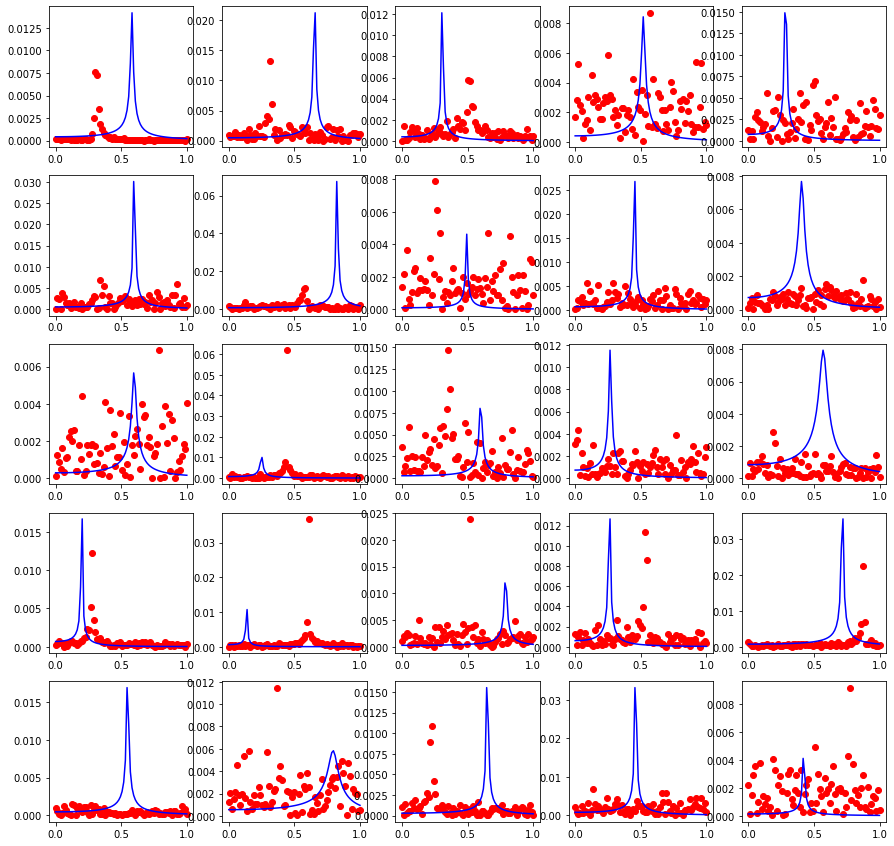

In [17]:
#We can plot them to see how the fits look
indices = np.random.choice(range(len(X_train)), size=25,replace = False)

fig, axes = plt.subplots(nrows=5, ncols=5, figsize = (15,15))

for ind, ax in enumerate(axes.flat):
    chosen_ind = indices[ind]
    parms = sho_fitter.model.predict(X_train[chosen_ind,:][None,:,:])
    fit_curve = SHO_fit_func_no_noise(wvec, *parms[0])

    ax.plot(wvec, np.abs(X_train[ind,:][:,0]), 'ro')
    ax.plot(wvec, np.abs(fit_curve), 'b-')

                         

                  

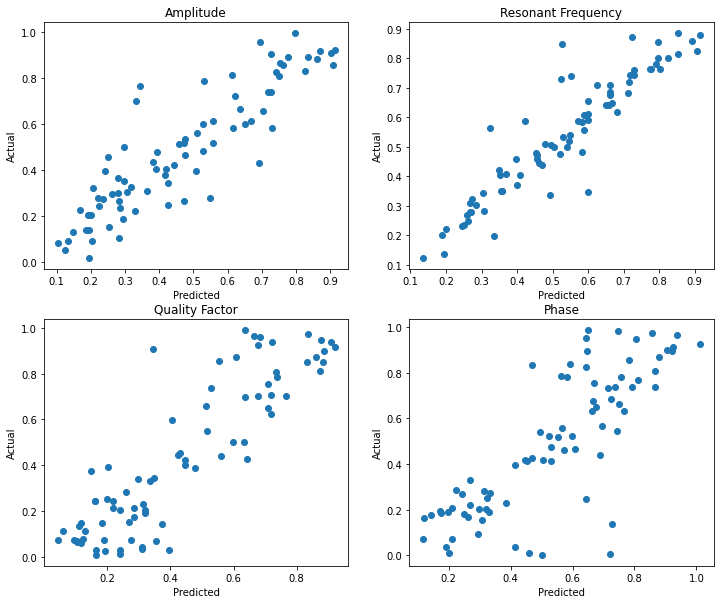

In [18]:
fig, axes = plt.subplots(nrows=2,ncols=2, figsize = (12,10))
title_list = ['Amplitude', 'Resonant Frequency', 'Quality Factor', 'Phase']
predictions = np.array(sho_fitter.model.predict(X_train))

for ind, ax in enumerate(axes.flat):
    
    ax.scatter(predictions[:,ind], y_train[:,ind])
    ax.set_title(title_list[ind])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')